X_train shape after preprocessing: (60000, 784)
Number of components to explain 95.0% variance: 154
X_pca shape: (60000, 154)

Performing K-Means clustering...
K-Means - Silhouette: 0.0628, DB: 2.7716, CH: 2459.6086


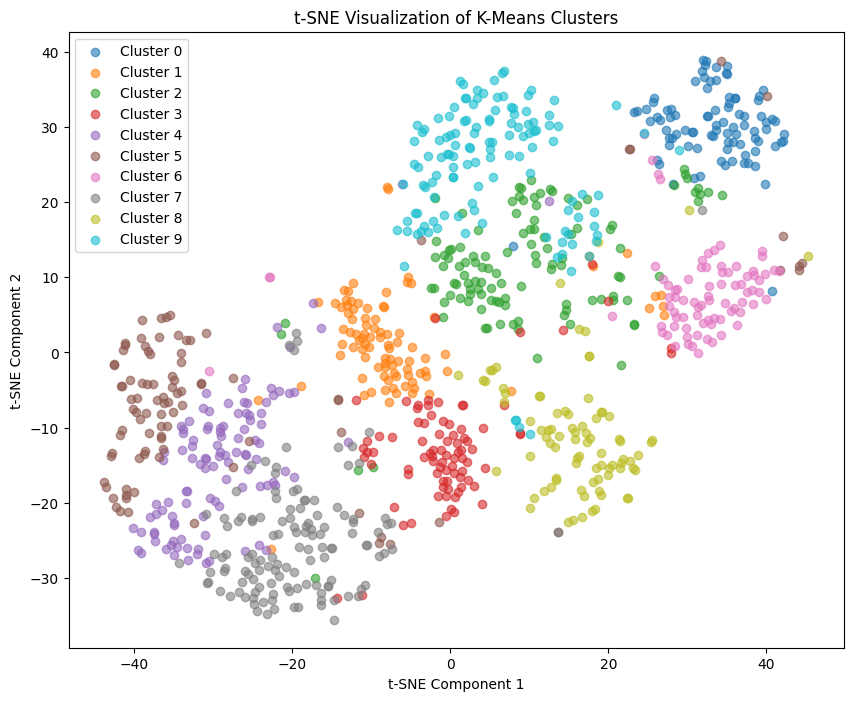


Performing MiniBatch K-Means clustering...
MiniBatch K-Means - Silhouette: 0.0581, DB: 2.7510, CH: 2390.5208


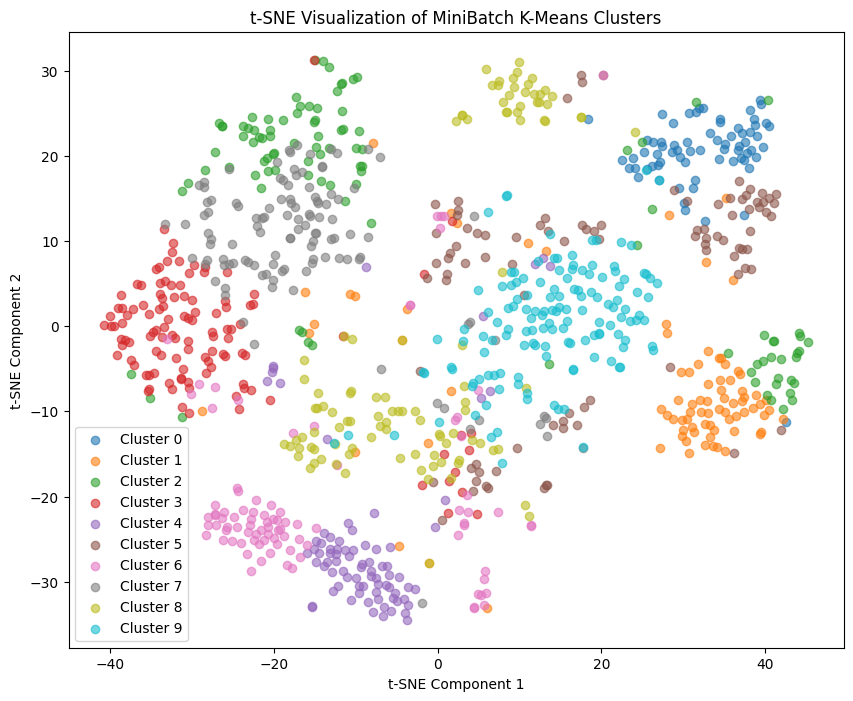


Performing Agglomerative Clustering clustering...


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load and Preprocess Data
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the MNIST-based dataset.
    
    Args:
        file_path (str): Path to the .npy file.
    
    Returns:
        np.ndarray: Preprocessed data of shape (n_samples, 784).
    """
    X = np.load(file_path)
    # Reshape from (60000, 1, 28, 28) to (60000, 784)
    X = X.reshape(X.shape[0], -1)
    # Normalize to [0, 1] assuming pixel values are 0-255
    X = X / 255.0
    return X

# 2. Dimensionality Reduction with PCA
def apply_pca(X, variance_ratio=0.95):
    """
    Apply PCA to reduce dimensionality while retaining specified variance.
    
    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        variance_ratio (float): Fraction of variance to retain (default: 0.95).
    
    Returns:
        np.ndarray: Reduced data.
    """
    pca = PCA()
    pca.fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= variance_ratio) + 1
    print(f'Number of components to explain {variance_ratio*100}% variance: {n_components}')
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

# 3. Clustering
def perform_clustering(X, algorithm='kmeans', n_clusters=10, random_state=42, **kwargs):
    """
    Perform clustering on the data using the specified algorithm.
    
    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        algorithm (str): Clustering algorithm ('kmeans', 'minibatch_kmeans', 'agglomerative').
        n_clusters (int): Number of clusters (default: 10).
        random_state (int): Random seed for reproducibility (default: 42).
        **kwargs: Additional arguments for the clustering algorithm.
    
    Returns:
        np.ndarray: Cluster labels.
    """
    if algorithm == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state, **kwargs)
    elif algorithm == 'minibatch_kmeans':
        clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state, **kwargs)
    elif algorithm == 'agglomerative':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, **kwargs)
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")
    labels = clusterer.fit_predict(X)
    return labels

# 4. Evaluation
def evaluate_clustering(X, labels):
    """
    Evaluate clustering performance using internal metrics.
    
    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        labels (np.ndarray): Cluster labels.
    
    Returns:
        tuple: (silhouette_score, davies_bouldin_score, calinski_harabasz_score).
    """
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        return sil_score, db_score, ch_score
    else:
        return -1, -1, -1

# 5. Visualization with t-SNE
def visualize_clusters(X, labels, algorithm_name, sample_size=1000):
    """
    Visualize clusters using t-SNE.
    
    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        labels (np.ndarray): Cluster labels.
        algorithm_name (str): Name of the clustering algorithm for the plot title.
        sample_size (int): Number of samples to visualize (default: 1000).
    """
    # Subsample for faster t-SNE computation
    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[idx]
        labels_sample = labels[idx]
    else:
        X_sample = X
        labels_sample = labels
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_sample)
    
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels_sample)
    for i in unique_labels:
        plt.scatter(X_tsne[labels_sample == i, 0], X_tsne[labels_sample == i, 1], 
                   label=f'Cluster {i}', alpha=0.6)
    plt.legend()
    plt.title(f't-SNE Visualization of {algorithm_name} Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Main Execution
if __name__ == "__main__":
    # File path
    file_path = '../datasets/unlabelled_train_data_images.npy'
    
    # Load and preprocess data
    X_train = load_and_preprocess_data(file_path)
    print(f"X_train shape after preprocessing: {X_train.shape}")
    
    # Apply PCA
    X_pca = apply_pca(X_train, variance_ratio=0.95)
    print(f"X_pca shape: {X_pca.shape}")
    
    # List of clustering algorithms to try
    algorithms = [
        ('kmeans', 'K-Means'),
        ('minibatch_kmeans', 'MiniBatch K-Means'),
        ('agglomerative', 'Agglomerative Clustering')
    ]
    
    # Perform clustering and evaluate
    for algo_key, algo_name in algorithms:
        print(f"\nPerforming {algo_name} clustering...")
        labels = perform_clustering(X_pca, algorithm=algo_key, n_clusters=10)
        sil_score, db_score, ch_score = evaluate_clustering(X_pca, labels)
        print(f"{algo_name} - Silhouette: {sil_score:.4f}, DB: {db_score:.4f}, CH: {ch_score:.4f}")
        visualize_clusters(X_pca, labels, algo_name)
        
        # Assign labels for the last algorithm (e.g., MiniBatch K-Means) as Y_train
        if algo_key == 'minibatch_kmeans':
            Y_train = labels
    
    print(f"\nX_train shape: {X_train.shape}")
    print(f"Y_train shape: {Y_train.shape}")